In [1]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure all rows and columns are printed
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

In [2]:
# load in the mouse and human atlases

human_labels = sitk.ReadImage("./unprocessed_data/human/mni_icbm152_CerebrA_tal_nlin_sym_09c.nii")
mouse_labels = sitk.ReadImage("./unprocessed_data/mouse/labelsReformat.nii")

human_labels_array = sitk.GetArrayFromImage(human_labels)
mouse_labels_array = sitk.GetArrayFromImage(mouse_labels)

print("human_labels_array dim:", human_labels_array.shape)
print("mouse_labels_array dim:", mouse_labels_array.shape)

human_labels_df = pd.read_csv("./atlases/human_CerebrA_LabelDetails.csv")
mouse_labels_df = pd.read_csv("./atlases/mouse_c57_brain_atlas_labels.csv")

# to aid with string matching convert all labels to lowercase
human_labels_df["Label Name"] = human_labels_df["Label Name"].astype(str).str.lower()

# Other overlapping labels include:

common_label_diff_names = { # "label_mouse": "label_human"
    "optic tract": "optic chiasm",
    "arbor vita of cerebellum": "cerebellum white matter",
    "nucleus accumbens": "accumbens area",
    "globus pallidus": "pallidum",
}


human_labels_array dim: (193, 229, 193)
mouse_labels_array dim: (548, 282, 420)


In [ ]:
# relabel the regions with the same values in the mouse and human datasets

# Find common elements
common = list(set(human_labels_df["Label Name"]) & set(mouse_labels_df["Structure"]))

# Print results
print("Number of common labels:", len(common))
print("Common labels:", common)


# want to give these the same labels to display in seg masks!!
# just relabel them to be greater the max of both images
# and relabel the intensity in the image
max_int = int(np.maximum(np.max(human_labels_array), np.max(mouse_labels_array)))

# check that matches the max label in dfs
max_dfs = np.maximum(np.max(human_labels_df[["RH Label", "LH Labels"]]), np.max(mouse_labels_df[["right label", "left label"]]))

new_label_val = max_int + 1

## ISSUE: woith hjow the keys are being extracted
dict_keys = [i for i in common_label_diff_names.keys()]
common += dict_keys
print("Updated common labels:",common)


# now relabel starting at 251, 252 pair
for label in common:
    print("label:", label)
    if (label in common_label_diff_names):
        label_mouse = label
        label_human = common_label_diff_names[label]
    else:
        label_mouse = label
        label_human = label

    # change the intensities in the image
    # get current intesities to know what pxls to filter
    human_right_intensity = human_labels_df["RH Label"][human_labels_df["Label Name"] == label_human].values[0]
    human_left_intensity = human_labels_df["LH Labels"][human_labels_df["Label Name"] == label_human].values[0]

    mouse_right_intensity = mouse_labels_df["right label"][mouse_labels_df["Structure"] == label_mouse].values[0]
    mouse_left_intensity = mouse_labels_df["left label"][mouse_labels_df["Structure"] == label_mouse].values[0]

    # overwrite these intensity values with the new ones
    # overwritting values in a numpy array
    human_labels_array[human_labels_array == human_right_intensity] = new_label_val
    mouse_labels_array[mouse_labels_array == mouse_right_intensity] = new_label_val

    human_labels_array[human_labels_array == human_left_intensity] = new_label_val + 1
    mouse_labels_array[mouse_labels_array == mouse_left_intensity] = new_label_val + 1

    
    # relabel both df labels
    human_labels_df.loc[human_labels_df["Label Name"] == label_human, "RH Label"] = new_label_val
    mouse_labels_df.loc[mouse_labels_df["Structure"] == label_mouse, "right label"] = new_label_val
    new_label_val += 1

    human_labels_df.loc[human_labels_df["Label Name"] == label_human, "LH Labels"] = new_label_val
    mouse_labels_df.loc[mouse_labels_df["Structure"] == label_mouse, "left label"] = new_label_val

    new_label_val += 1



Number of common labels: 7
Common labels: ['basal forebrain', 'fourth ventricle', 'hippocampus', 'amygdala', 'thalamus', 'lateral ventricle', 'third ventricle']
Updated common labels: ['basal forebrain', 'fourth ventricle', 'hippocampus', 'amygdala', 'thalamus', 'lateral ventricle', 'third ventricle', 'optic tract', 'arbor vita of cerebellum', 'nucleus accumbens', 'globus pallidus']
label: basal forebrain
label: fourth ventricle
label: hippocampus
label: amygdala
label: thalamus
label: lateral ventricle
label: third ventricle
label: optic tract
label: arbor vita of cerebellum
label: nucleus accumbens
label: globus pallidus


In [4]:
def nearest_neighbour_resampling(ref_img, move_img):
    resampler = sitk.ResampleImageFilter()

    # set resampler parameters
    resampler.SetReferenceImage(ref_img)
    resampler.SetInterpolator(sitk.sitkLinear)
    #resampler.SetOutputSpacing(ref_img.GetSpacing())
    #resampler.SetSize(ref_img.GetSize())
    #resampler.SetDefaultPixelValue(0) # background

    return resampler.Execute(move_img)

In [5]:
# save the updated labeled atlases
mouse_labels_img = sitk.GetImageFromArray(mouse_labels_array)
human_labels_img = sitk.GetImageFromArray(human_labels_array)


# align atlases - rotate the mouse atlas to have the same axis as the human atlas
# currently the mouse z slice is thec coronal plane, want to be the transverse plane
mouse_labels_img_permute = sitk.PermuteAxes(mouse_labels_img, [0, 2, 1])

sitk.WriteImage(mouse_labels_img_permute, "./atlases/mouse_labels_common.nii")
sitk.WriteImage(human_labels_img, "./atlases/human_labels_common.nii")

mouse_labels_df.to_csv("./atlases/mouse_labels_common.csv", index=False)
human_labels_df.to_csv("./atlases/human_labels_common.csv", index=False)



In [6]:
mouse_arr = sitk.GetArrayFromImage(mouse_labels_img_permute)
human_arr = sitk.GetArrayFromImage(human_labels_img)

print(mouse_arr.shape)
print(human_arr.shape)

(282, 548, 420)
(193, 229, 193)


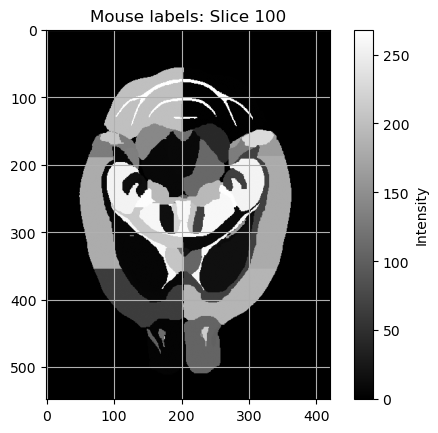

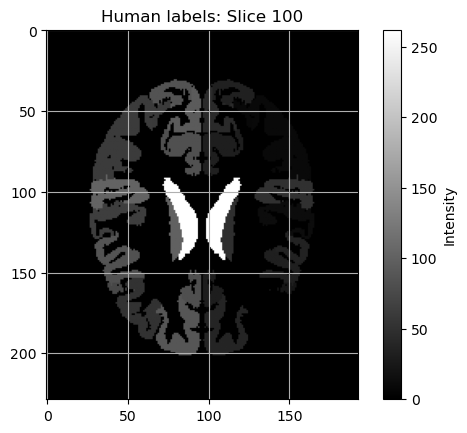

In [7]:
z_slice = 100
mouse_labels_seg_mask_slice = mouse_arr[z_slice, :, :]

plt.figure()
plt.imshow(mouse_labels_seg_mask_slice, cmap="gray") 
plt.colorbar(label="Intensity")
plt.title(f"Mouse labels: Slice {z_slice}")
plt.grid(True)
plt.show()

human_labels_seg_mask_slice = human_arr[z_slice, :, :]

plt.figure()
plt.imshow(human_labels_seg_mask_slice, cmap="gray") 
plt.colorbar(label="Intensity")
plt.title(f"Human labels: Slice {z_slice}")
plt.grid(True)
plt.show()

In [25]:

def crop_brain(img_np):
    # find mix/max x,y,z that have a nonzero value
    # to comoute the bounding box of the labels
    non_zero_indices = np.argwhere(img_np != 0)

    min_coords = np.min(non_zero_indices, axis=0)
    max_coords = np.max(non_zero_indices, axis=0)

    # crop the image array to that bounding vbox
    return img_np[min_coords[0]:max_coords[0], min_coords[1]:max_coords[1], min_coords[2]:max_coords[2]]


def scale_dimensions(ref_img, move_img):
    # Get the size of the reference image
    ref_size = ref_img.GetSize()
    move_size = move_img.GetSize()

    ref_y = ref_size[1]
    move_y = move_size[1]

    transform = sitk.ScaleTransform(3)

    # scale to match in x dimension while keeping aspect ratio
    scale_by =  ref_y / move_y

    new_size = [
        int(move_size[0]*scale_by),
        int(move_size[1]*scale_by),
        int(move_size[2]*scale_by),
    ]

    transform.SetScale([1/scale_by, 1/scale_by, 1/scale_by])

    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(new_size)
    # resampler.SetInterpolator(sitk.sitkLinear) # linear might average pixels which isntttt ok
    resampler.SetInterpolator(sitk.sitkNearestNeighbor)
    resampler.SetTransform(transform)

    resampler.SetOutputSpacing(ref_img.GetSpacing())
    resampler.SetOutputOrigin(ref_img.GetOrigin())
    resampler.SetOutputDirection(ref_img.GetDirection())
    

    return resampler.Execute(move_img)

    

cropped mouse shape: (231, 501, 325)
cropped human shape: (160, 181, 144)
cropped and scaled human shape: (442, 501, 398)


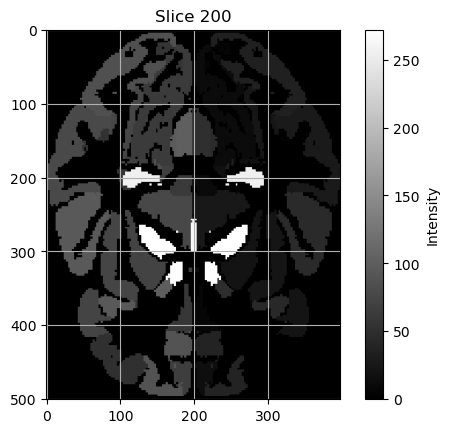

In [27]:
# Place in a comparable place
z_slice = 200

# step 1: crop the atlases to only the non background
mouse_arr_cropped = crop_brain(mouse_arr)
human_arr_cropped = crop_brain(human_arr)

print("cropped mouse shape:", mouse_arr_cropped.shape)
print("cropped human shape:", human_arr_cropped.shape)

# step 2: scale the smaller human img to the mouse dimension
mouse_cropped = sitk.GetImageFromArray(mouse_arr_cropped)
human_cropped = sitk.GetImageFromArray(human_arr_cropped)

human_cropped_and_scaled = scale_dimensions(ref_img=mouse_cropped, move_img=human_cropped)
human_arr_c_a_s = sitk.GetArrayFromImage(human_cropped_and_scaled)

# flip mouse image
mouse_cropped = sitk.Flip(mouse_cropped, [True, True, False])

# NOTE: temp save before padding
sitk.WriteImage(mouse_cropped, "./atlases/mouse_labels_common_cropped.nii")
sitk.WriteImage(human_cropped_and_scaled, "./atlases/human_labels_common_cropped_and_scaled.nii")

print("cropped and scaled human shape:", human_arr_c_a_s.shape)

# Visualize a slice
slice = human_arr_c_a_s[z_slice, :, :]

plt.figure()
plt.imshow(slice, cmap="gray") 
plt.colorbar(label="Intensity")
plt.title(f"Slice {z_slice}")
plt.grid(True)
plt.show()

In [10]:
human_labels_df

,Mindboggle ID,Label Name,RH Label,LH Labels,Notes,Dice Kappa
0,2002,caudal anterior cingulate,30,81,NaN,0.79
1,2003,caudal middle frontal,42,93,Improved distinction from Precentral,0.73
2,2005,cuneus,43,94,NaN,0.67
3,2006,entorhinal,36,87,Improved delimitation,0.78
4,2007,fusiform,24,75,NaN,0.77
5,2008,inferior parietal,10,61,NaN,0.75
6,2009,inferior temporal,3,54,Removed dorsal part MT,0.72
7,2010,isthmus cingulate,33,84,NaN,0.79
8,2011,lateral occipital,34,85,NaN,0.76
9,2012,lateral orbitofrontal,7,58,NaN,0.80


In [11]:
mouse_labels_df

,ID,Structure,right label,left label,hierarchy,tissue type,boundary
0,1,amygdala,257,258,NaN,WM,inside
1,2,anterior commissure: pars anterior,115,215,NaN,WM,inside
2,3,anterior commissure: pars posterior,23,103,NaN,WM,inside
3,4,arbor vita of cerebellum,267,268,NaN,WM,inside
4,5,basal forebrain,251,252,NaN,WM,inside
5,6,bed nucleus of stria terminalis,176,76,NaN,WM,inside
6,7,cerebellar cortex,202,2,NaN,WM,inside
7,8,cerebellar peduncle: inferior,123,223,NaN,WM,inside
8,9,cerebellar peduncle: middle,45,245,NaN,WM,inside
9,10,cerebellar peduncle: superior,242,222,NaN,WM,inside
